DSBA-6165 - Project - Stage 5<br>
Final Model<br><br>
Group 2:<br>
<li>Michael Tricanowicz

# Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import torch

In [2]:
# Set global random state variable
random_state = 20256165

## Load the Balanced Dataset

Load the dataset from the created PyTorch file.

In [3]:
# Load the dataset
data = torch.load("balanced_dataset.pt")
print("Dataset loaded successfully!")

C:\Users\trica\AppData\Local\Temp\ipykernel_544\3710203399.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("balanced_dataset.pt")


Dataset loaded successfully!


In [4]:
# Check number of images
print(len(data))

2147


## Split Images and Labels

In [5]:
# Create an index for the data to use as a link to original set once train/test split is done
index = np.arange(len(data))

In [6]:
# Extract images as the independent feature
X = torch.stack([img.squeeze(0) for _, (labels, img) in data.items()])  # Remove extra dim

In [7]:
# Create a mapping of the labels with "Not Labeled" included
unique_labels = sorted(set(label for labels, _ in data.values() for label in (labels if labels else ["Not Labeled"])))  
label_to_idx = {label: i for i, label in enumerate(unique_labels)}

In [8]:
# Extract labels as the dependent feature as a multi-hot encoded vector
y = torch.zeros((len(data), len(unique_labels)), dtype=torch.float32)
for i, (labels, _) in enumerate(data.values()):
    if not labels:
        y[i, label_to_idx["Not Labeled"]] = 1  # Assign "Not Labeled" class
    else:
        for label in labels:
            y[i, label_to_idx[label]] = 1  # Assign correct labels

## Confirm the count and visualize the class distribution in the dataset

In [9]:
# Define function to count labels and store in dictionary
def label_count(y):
    label_count = torch.zeros(y.shape[1], dtype=torch.int32)
    for i in range(len(y)):
        for j in range(len(y[i])):
            label_count[j] += y[i][j].int()
    return {label: int(label_count[idx]) for label, idx in label_to_idx.items()}

In [10]:
# Define function to plot histogram of label counts
import seaborn as sns
def plot_label_counts(y, y2=None):
    plt.figure(figsize=(10, 5))
    if y2 is not None:
        label_to_count_y = label_count(y)
        label_to_count_y2 = label_count(y2)
        counts_df = pd.DataFrame({
            "Class": label_to_count_y.keys(),
            "Train": label_to_count_y.values(),
            "Test": label_to_count_y2.values()
        })
        counts_df = counts_df.melt(id_vars="Class", var_name="Dataset", value_name="Count")
        ax = sns.barplot(data=counts_df, x="Class", y="Count", hue="Dataset")
    else:
        label_to_count = label_count(y)
        ax = sns.barplot(x=list(label_to_count.keys()), y=list(label_to_count.values()))
    plt.xlabel("Label", fontsize=12)
    plt.ylabel("Count of Images", fontsize=12)
    plt.title("Distribution of Labels in Dataset", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    # Annotate bars with counts
    for p in ax.patches:
        ax.annotate(
            f'{int(p.get_height())}',  # set the annotation to the height (value) of the bar
            (p.get_x() + p.get_width() / 2, p.get_height()),  # center annotation at the top of the bar
            ha='center',
            va='bottom'
        )
    plt.show()

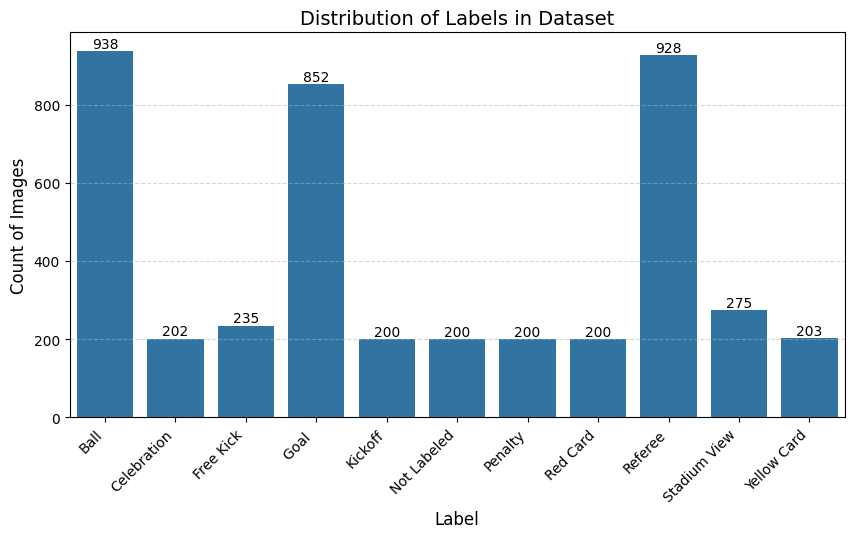

In [11]:
# Plot the labels
plot_label_counts(y)

## Create train and test datasets

In [12]:
# Prepare to split into train and test datasets for modeling
from sklearn.model_selection import train_test_split # import necesary library
test_size = 0.20 # global test size variable

In [13]:
# Import additional torch modules
from torch.utils.data import TensorDataset, DataLoader, random_split

In [14]:
# Train-test split
index_train, index_test, X_train, X_test, y_train, y_test = train_test_split(index, X, y, test_size=test_size, random_state=random_state)

In [15]:
print("X_train shape:", X_train.shape)  # check shape of the train X array which should be (num_samples, num channels, img_dim, img_dim)
print("X_test shape:", X_test.shape)  # check shape of the test X array which should be (num_samples, num channels, img_dim, img_dim)
print("y_train length:", len(y_train)) # check train label length which should be num_samples
print("y_test length:", len(y_test)) # check test label length which should be num_samples

X_train shape: torch.Size([1717, 3, 224, 224])
X_test shape: torch.Size([430, 3, 224, 224])
y_train length: 1717
y_test length: 430


In [16]:
# Use TensorDataset instead for loading via DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

## Count and visualize the class distribution between train and test sets

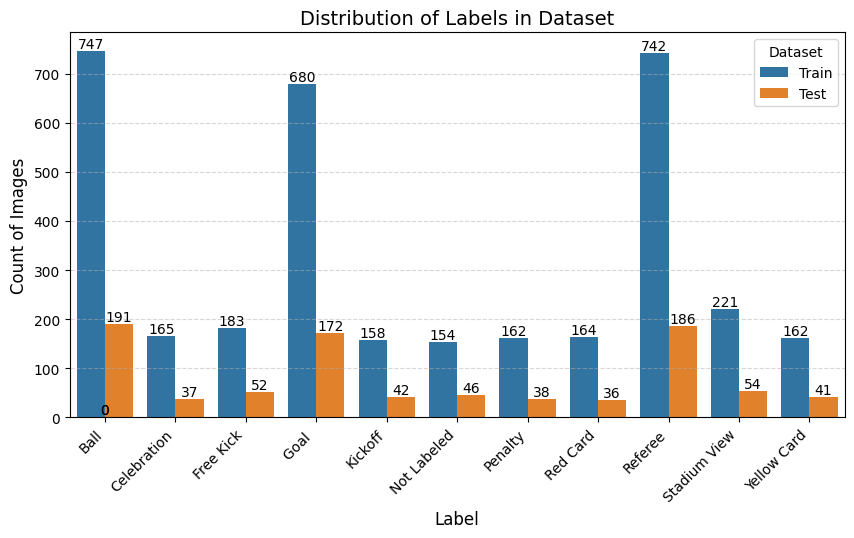

In [17]:
# Plot comparison of label distribution between the train and test sets
plot_label_counts(y_train, y_test)

## Visualize some images to confirm successful prep

In [18]:
# Define function to show an image where x is an image
def show_img(x, title="", bot="", fontsize=10):
    if isinstance(x, torch.Tensor):  # check whether the image is in tensor formate
        x = x.detach().cpu().numpy()  # if it is convert to NumPy and ensure it is moved to CPU
    if x.ndim == 3 and x.shape[0] in [1, 3]:  
        x = x.transpose(1, 2, 0)  # convert from (C, H, W) to (H, W, C) to work with imshow
    plt.imshow(x)
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])
    plt.xlabel(bot, fontsize=fontsize)
    plt.title(title, fontsize=fontsize)
    plt.plot()

In [19]:
# Define function to revert the multi-hot encoded label index to the labels that are present for display
def present_labels(y):
    present_labels = []
    index_to_label = {v: k for k, v in label_to_idx.items()}
    present_labels = [index_to_label[i] for i, value in enumerate(y) if value == 1]
    return present_labels

In [20]:
# Define function to show some number of images where X is an array of images, y is an array of labels, and n_images is the number of images to be displayed
import math
def display_images(X, y, index, n_images, data):
    plt.figure(figsize=(10 if n_images>=5 else 2*n_images, 2*math.ceil(n_images/5)))
    j=0
    for i in random.sample(range(len(X)), n_images):
        # Plot images with labels
        plt.subplot(math.ceil(n_images/5), 5 if n_images>=5 else n_images, j+1)
        show_img(
            X[i],
            title=", ".join(label.strip() for label in present_labels(y[i])),
            bot=f"Image {list(data.keys())[index[i]]}" # Note, the image # is from the image dictionary and comes from the filename in the original dataset
            )
        plt.plot()
        j += 1
    plt.tight_layout()

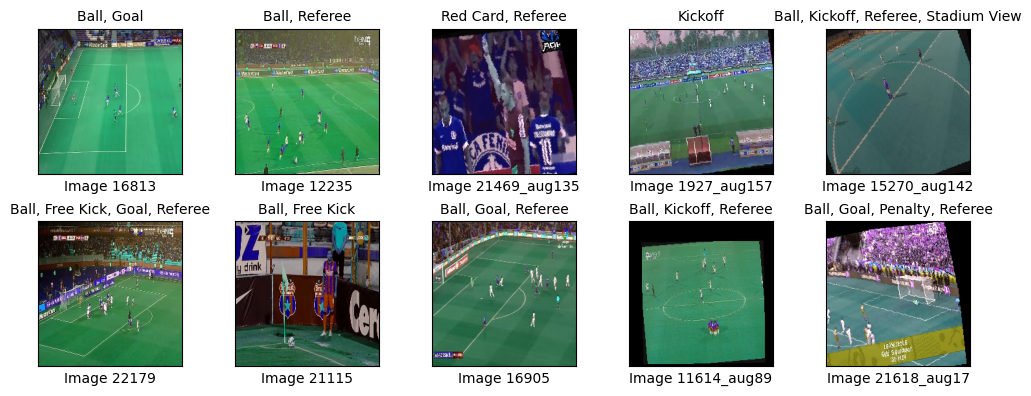

In [21]:
# Preview Train data
# Set the number images to preview
n_images_train = 10
# Show the images
display_images(X_train, y_train, index_train, n_images_train, data)

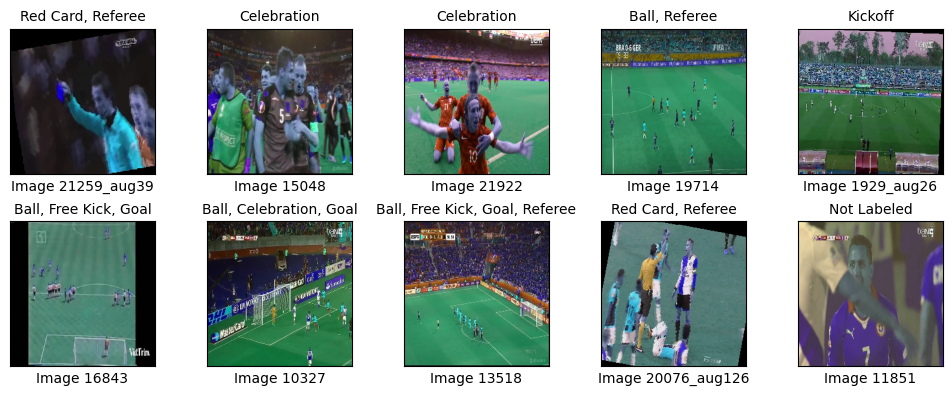

In [22]:
# Preview Test data
# Set the number images to preview
n_images_test = 10
# Show the images
display_images(X_test, y_test, index_test, n_images_test, data)

# Model

## Setup

In [23]:
# Import additional Torch libraries
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

In [24]:
# Create global batch size variable
batch_size = 32

In [25]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [26]:
# Check DataLoader output
for imgs, labels in train_loader:
    print(imgs.shape, labels.shape)  # Expected: torch.Size([batch_size, channels (3), height (224), width (224)]) torch.Size([batch_size, num_labels (11)])
    break

torch.Size([32, 3, 224, 224]) torch.Size([32, 11])


In [27]:
# Check which device is available and being used. Use GPU if available.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Define and Build Model

For the baseline model, a CNN was created using PyTorch to mimic the structure and architecture of the LeNet-5 model as shown in Figure 27 of the Lecture 6 slides. Adjustments were made to account for the different input size. LeNet-5 was built for grayscale 28x28 images, but this model is evaluating RGB 224x224 images.<br>

In seeking to improve upon the performance of the baseline model, several changes were implemented to integrate more modern techniques, increase robustness, and achieve greater recall, precision, and accuracy in the classifications. Modifications include:
- Use [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) to create Max Pooling layers instead of Average Pooling.
    - Max pooling should more effectively identify features related to the target labels since it keeps the strongest activations. It is assumed that these strongest features are more likely to identify changes in objects within the frame and therefore provide a more effective means to learn and differentiate between different classes.
    - Max pooling is typically used in modern CNN architecture including AlexNet, ResNet, and VGGNet.
- Set the Pooling stride less than the kernel to provide overlap in the pooling layer.
    - Per Krizhevsky et al in [ImageNet Classification with Deep Convolutional Neural Networks](https://dl.acm.org/doi/pdf/10.1145/3065386), paragraph 4.4 details reduction in error rates achieved by setting stride (s) less than kernel (z). In their case, s=2 and z=3 was used. The overlapping pooling also reduced overfitting in the models.
- Experimented with replacing the fully connected layers with a global average pooling layer using [AdaptiveAvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d).
    - Global average pooling will allow the model to adapt to any input image size and won't tie it to dimensions associated with a 224x224 image.
    - This will simplify the model by eliminated fully connected layers. It also helps improves model robustness and efficiency by reducing parameters which can prevent overfitting and decrease model size and complexity.
    - Global average pooling was introduced into ResNet by He et al in [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385).
    - This drastically reduced the number of parameters and model size, however it also made the model extremely inaccurate even if training epochs were increased.
    - **Decision was made not to keep this change implemented.**
- Implement an adaptive pooling layer before the fully connected layers instead using [AdaptiveMaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveMaxPool2d.html#torch.nn.AdaptiveMaxPool2d).
    - This will standardize the output size of the convolution so that the fully connected layer size is no longer fixed on an output size that is tied to an input image of 224x224 passing through two specific convolution layers. This will make the model more adaptable and will allow experimentation (including adding and/or changing convolutional layers) without needing to adjust the fully connected layer and flatten operation every time.
    - This also reduces the number of parameters by decreasing the convolution output size prior to passing to the fully connected layers. This results in a less complex model that takes up less memory and should train faster.
    - A 6x6 output size is consistent with the Max Pool output used by AlexNet.
- Increase output size of subsequent convolution layers
    - Set output channels to 6x the previous layer
    - Increases filters and learning capacity of the model
- Add a third convolution layer to increase parameters and improve learning
    - 3x3 convolution with 216 output channels and no padding.
    - Third layer is inspried by the AlexNet architecture which adds a third 3x3 convolution. This model, however, does not use padding in this layer and has fewer output channels than AlexNet. All of the convolution layers in this model were sized between LeNet and AlexNet.
- Increase size of fully connected layers to add parameters
    - Improves model prediction performance by increasing the number of neurons that can learn and vote on features
- Added Batch Normalization layers using [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d) for the convolution layers and [BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d) for the fully connected layers.
    - This technique speeds up training and improves generalization of the model by normalizing the batches over the channels to eliminate input variations.
    - Methodology described by Ioffe and Szegedy in [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d).
- Where feasible, changed parameters of layers to be dynamically defined rather than explicitly set to make the model more adaptable to architecture changes without needed to manually edit components of it.
- Allowed longer training but implemented early stopping.
    - Doubled maximum training epochs from 10 to 20.
    - Implemented early stopping to end training if 3 consecutive epochs pass without a reduction in loss.
    - Will potentially permit additional learning and improved model performance, but will avoid unnecessary lengthening training time and computational costs.

In [28]:
# Modified CNN model originally based on LeNet architecture as shown in Lecture 6 page 38 of 39.
# Implemented elements of AlexNet and ResNet to try to improve model performance
 
class michaelnetCNN(nn.Module): 
    def __init__(self, num_labels):
        super(michaelnetCNN, self).__init__()
        
        # Convolution layers
        # Conv layers (5x5 convolution with 6 output channels and padding of 2)
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, padding=2)     
        # Conv layer 2 (5x5 convolution with 6x previous output channels and no padding)
        self.conv2 = nn.Conv2d(self.conv1.out_channels, 6*self.conv1.out_channels, kernel_size=5)
        # Add a third conv layer (3x3 convolution with 6x previous output channels and no padding)
        self.conv3 = nn.Conv2d(self.conv2.out_channels, 6*self.conv2.out_channels, kernel_size=3)
        
        # Batch normalization for convolution layers to improve generalization
        self.bn_conv1 = nn.BatchNorm2d(self.conv1.out_channels)
        self.bn_conv2 = nn.BatchNorm2d(self.conv2.out_channels)
        self.bn_conv3 = nn.BatchNorm2d(self.conv3.out_channels)

        # Use MAX pooling instead of AVG pooling. Use overlapping instead of local pooling by setting stride less than kernel. (3x3 max pooling with stride 2)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        
        # Introduce adaptive pooling layer to allow the model to handle any input image size and preceding sequence of layers
        self.adaptive_pool = nn.AdaptiveMaxPool2d((6, 6)) # takes any input size and outputs a 6x6 feature map

        # Fully connected layers (120 neurons followed by 84 neurons followed by 11 neurons (one for each label))
        self.fc1 = nn.Linear(self.conv3.out_channels * 6 * 6, 512)  # inputs the flattened layer with channels defined by last conv output, outputs 120 neuron layer
        self.fc2 = nn.Linear(self.fc1.out_features, 128)  # outputs 84 neuron layer
        self.fc3 = nn.Linear(self.fc2.out_features, num_labels)  # outputs num_labels which will be the number of labels in multi-hot encoding

        # Batch normalization for fully connected layers to improve generalization
        self.bn_fc1 = nn.BatchNorm1d(self.fc1.out_features)
        self.bn_fc2 = nn.BatchNorm1d(self.fc2.out_features)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.bn_conv1(self.conv1(x))))  # Apply convolution + ReLU + Pooling
        x = self.pool(nn.functional.relu(self.bn_conv2(self.conv2(x))))  # Apply convolution 2 + ReLU + Pooling
        x = self.pool(nn.functional.relu(self.bn_conv3(self.conv3(x))))  # Apply convolution 3 + ReLU + Pooling
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)  # Flatten the output (after pooling), flatten size becomes batch_size x adaptive_pool output size
        x = nn.functional.relu(self.bn_fc1(self.fc1(x)))  # Fully connected layer
        x = nn.functional.relu(self.bn_fc2(self.fc2(x)))  # Fully connected layer 2        
        x = self.fc3(x)  # Apply fully connected layer (output layer, raw logits for multi-label classification)
        return x

In [29]:
# Review the model's structure
summary(michaelnetCNN(len(label_to_idx.keys())), input_size=(3,224,224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 224, 224]             456
       BatchNorm2d-2          [-1, 6, 224, 224]              12
         MaxPool2d-3          [-1, 6, 111, 111]               0
            Conv2d-4         [-1, 36, 107, 107]           5,436
       BatchNorm2d-5         [-1, 36, 107, 107]              72
         MaxPool2d-6           [-1, 36, 53, 53]               0
            Conv2d-7          [-1, 216, 51, 51]          70,200
       BatchNorm2d-8          [-1, 216, 51, 51]             432
         MaxPool2d-9          [-1, 216, 25, 25]               0
AdaptiveMaxPool2d-10            [-1, 216, 6, 6]               0
           Linear-11                  [-1, 512]       3,981,824
      BatchNorm1d-12                  [-1, 512]           1,024
           Linear-13                  [-1, 128]          65,664
      BatchNorm1d-14                  [

In [30]:
pd.DataFrame(summary(michaelnetCNN(len(label_to_idx.keys())), input_size=(3,224,224), device="cpu")).to_csv("michaelnet_summary.csv")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 224, 224]             456
       BatchNorm2d-2          [-1, 6, 224, 224]              12
         MaxPool2d-3          [-1, 6, 111, 111]               0
            Conv2d-4         [-1, 36, 107, 107]           5,436
       BatchNorm2d-5         [-1, 36, 107, 107]              72
         MaxPool2d-6           [-1, 36, 53, 53]               0
            Conv2d-7          [-1, 216, 51, 51]          70,200
       BatchNorm2d-8          [-1, 216, 51, 51]             432
         MaxPool2d-9          [-1, 216, 25, 25]               0
AdaptiveMaxPool2d-10            [-1, 216, 6, 6]               0
           Linear-11                  [-1, 512]       3,981,824
      BatchNorm1d-12                  [-1, 512]           1,024
           Linear-13                  [-1, 128]          65,664
      BatchNorm1d-14                  [

The changes made tried to balance adding parameters and complexity to increase learning capacity with adjustments to reduce parameters and improve generalization. To that end, the updated model ended up with fewer parameters but is larger in size.<br>
Parameter Reduction: 5,612,811 -> 4,126,795 (approximately -26.5%)<br>
Size Reduction: 26.64 MB -> 38.21 MB (approximately +43.4%)

In [31]:
# Define the model and load it to GPU if available
model = michaelnetCNN(len(label_to_idx.keys()))
model.to(device)

michaelnetCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 36, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(36, 216, kernel_size=(3, 3), stride=(1, 1))
  (bn_conv1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_conv2): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_conv3): BatchNorm2d(216, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(6, 6))
  (fc1): Linear(in_features=7776, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=11, bias=True)
  (bn_fc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_fc2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [32]:
# Set hyperparameters 
learning_rate = 0.001
epochs = 20
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Train Model

In [33]:
%%time
# Train model
# Initialize variables that will be used for early stopping
patience = 3 # number of epochs permitted without improvement
best_loss = float("inf") # best loss initially set to infinity to ensure the model isn't inadvertently stopped, will be updated to store the best (lowest) loss achieved after each train loop
no_improvement_epochs = 0 # counter that will increment if loss is not lower than previously recorded best_loss

# Train loop
train_losses = [] # initialize variable to store each epoch loss
for epoch in range(epochs):
    epoch_loss = 0.0 # initialize variable for epoch loss
    model.train() # set model to train
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.float().to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
        # Print progress messages
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    epoch_loss /= len(train_loader) # calculate average loss for the epoch
    print(f'Epoch [{epoch + 1}/{epochs}] Epoch Loss: {epoch_loss:.4f}')
    
    train_losses.append(epoch_loss) # store the losses of each epoch

    if epoch_loss < best_loss:
        best_loss = epoch_loss # update best_loss if current loop is an improvement
        no_improvement_epochs = 0  # reset the counter
    else:
        no_improvement_epochs += 1 # increment the counter if there is no improvement
        print(f"Epochs without improvement: {no_improvement_epochs}/{patience}")
    
    if no_improvement_epochs >= patience: # stop training if no improvement in loss value has occurred for number of consecutive epochs equal to patience variable set above
        print(f"Early stopping occurred at epoch {epoch + 1}.")
        break 

Epoch [1/20], Step [10/54], Loss: 0.5412
Epoch [1/20], Step [20/54], Loss: 0.4308
Epoch [1/20], Step [30/54], Loss: 0.3514
Epoch [1/20], Step [40/54], Loss: 0.3281
Epoch [1/20], Step [50/54], Loss: 0.3217
Epoch [1/20] Epoch Loss: 0.4251
Epoch [2/20], Step [10/54], Loss: 0.2830
Epoch [2/20], Step [20/54], Loss: 0.2729
Epoch [2/20], Step [30/54], Loss: 0.2819
Epoch [2/20], Step [40/54], Loss: 0.2317
Epoch [2/20], Step [50/54], Loss: 0.2673
Epoch [2/20] Epoch Loss: 0.2624
Epoch [3/20], Step [10/54], Loss: 0.2095
Epoch [3/20], Step [20/54], Loss: 0.2285
Epoch [3/20], Step [30/54], Loss: 0.2241
Epoch [3/20], Step [40/54], Loss: 0.2059
Epoch [3/20], Step [50/54], Loss: 0.1740
Epoch [3/20] Epoch Loss: 0.2054
Epoch [4/20], Step [10/54], Loss: 0.1479
Epoch [4/20], Step [20/54], Loss: 0.1654
Epoch [4/20], Step [30/54], Loss: 0.1759
Epoch [4/20], Step [40/54], Loss: 0.2267
Epoch [4/20], Step [50/54], Loss: 0.1546
Epoch [4/20] Epoch Loss: 0.1673
Epoch [5/20], Step [10/54], Loss: 0.1264
Epoch [5/20

Reducing model complexity also improved training time (approx 1 minute 10 seconds -> approx 53 seconds) by about 25%.

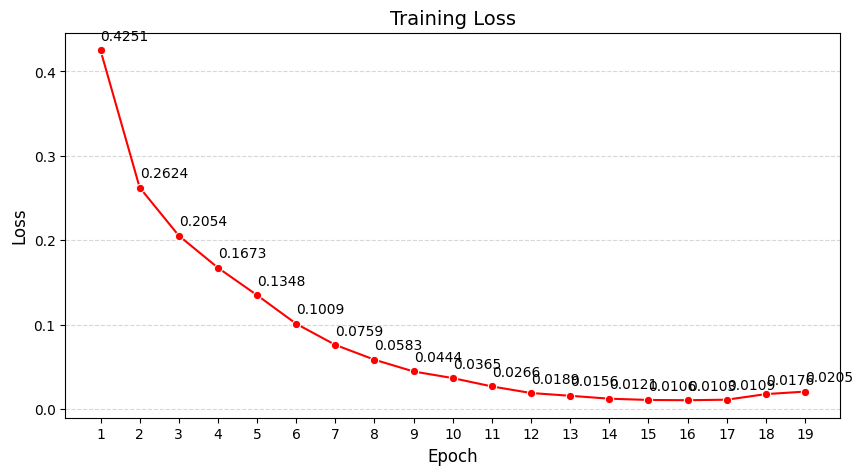

In [34]:
# Plot training loss
plt.figure(figsize=(10, 5))
ax = sns.lineplot(x=range(1, len(train_losses)+1), y=train_losses, color="red", marker="o")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training Loss", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(range(1, len(train_losses)+1))
# Annotate each point on the line with its value
for epoch, loss in zip(range(1, epochs+1), train_losses):
    ax.annotate(
        f'{loss:.4f}',  # Annotate the point with the loss value (formatted to 4 decimal places)
        (epoch, loss),  # Position the annotation at the (epoch, loss) coordinates
        textcoords="offset points",  # Use an offset to prevent overlap with the line
        xytext=(0, 5),  # Slightly offset the text from the point (5 pixels above)
        ha="left",  # Center the text horizontally
        va="bottom"   # Align the text to the bottom of the point
    )
plt.show()

## Test Model

In [35]:
%%time
# Test model
# Create variables to calculate and update accuracy within each sample
correct, total = 0, 0
# Create a variable to store predictions
test_images = []
test_labels = []
predictions = []

# Define a threshold for classification
threshold = 0.5 # if logit is >=0.5 assign the label

# Run the model on the test samples
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader, 0):
        images, labels = images.float().to(device), labels.to(device)
        outputs = model(images)
        # Apply sigmoid activation to get probabilities for each label
        probs = torch.sigmoid(outputs)
        predicted = (probs > threshold).float() # predict label if its probability meets threshold

        total += labels.numel()
        correct += (predicted == labels).sum().item()

        test_images.append(images)
        test_labels.append(labels)
        predictions.append(predicted)

print(f"Accuracy on the test set: {correct/total:.2%}")

Accuracy on the test set: 92.20%
CPU times: total: 4.73 s
Wall time: 5.28 s


In [36]:
# Define function to visualize image label predictions
def display_predictions(X, predicted, actual, index, n_images, fontsize=10):
    plt.figure(figsize=(10 if n_images>=5 else 2*n_images, 2*math.ceil(n_images/5)))
    j=0
    # Copy image tensors to CPU to work with numpy
    X=X.cpu()
    predicted=predicted.cpu().tolist()
    actual=actual.cpu().tolist()
    # Prep images
    random.seed(random_state)
    for i in random.sample(range(len(X)), n_images):
        plt.subplot(math.ceil(n_images/5), 5 if n_images>=5 else n_images, j+1)
        show_img(
            X[i],
            title=f"Predicted: {', '.join(present_labels(predicted[i]))}",
            bot=f"Actual: {', '.join(present_labels(actual[i]))}\nImage {list(data.keys())[index[i]]}",
            fontsize=fontsize
            )
        plt.plot()
        j += 1
    plt.tight_layout()

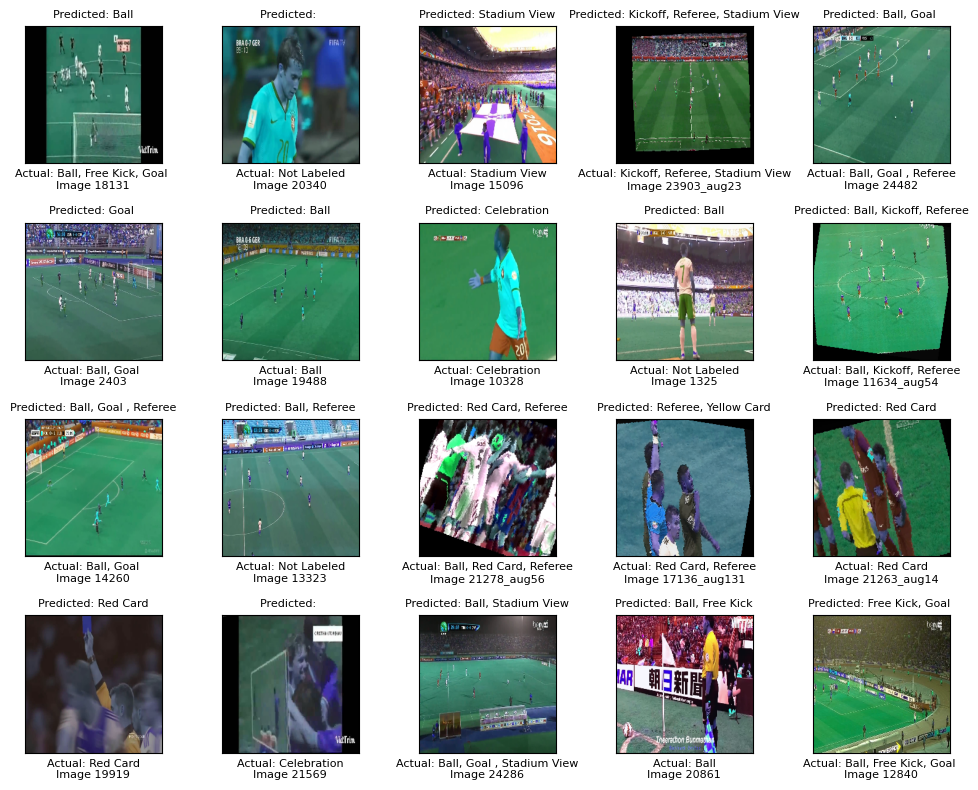

In [37]:
# Visualize Test predictions
# Set the number images to preview
n_images_pred = 20
# Show the images
display_predictions(torch.cat(test_images), torch.cat(predictions), torch.cat(test_labels), index_test, n_images_pred, fontsize=8)

In [38]:
# Generate classification metrics for the model performance on the test data
from sklearn.metrics import multilabel_confusion_matrix, classification_report
idx_to_label = {v: k for k, v in label_to_idx.items()} # reverse the labels to index dictionary
confusion_matrices = multilabel_confusion_matrix(torch.cat(test_labels).cpu(), torch.cat(predictions).cpu()) # generate confusion matrices for each label
report = classification_report(torch.cat(test_labels).cpu(), torch.cat(predictions).cpu(), zero_division=np.nan, labels=(list(idx_to_label.keys())), target_names=(list(idx_to_label.values())), output_dict=True) # generate classification report and store in dictionary
report_display = classification_report(torch.cat(test_labels).cpu(), torch.cat(predictions).cpu(), zero_division=np.nan, labels=(list(idx_to_label.keys())), target_names=(list(idx_to_label.values())), output_dict=False) # generate classification report for display

In [39]:
# Display classification report
print(report_display)

              precision    recall  f1-score   support

        Ball       0.74      0.68      0.71       191
 Celebration       0.79      0.62      0.70        37
   Free Kick       0.84      0.73      0.78        52
       Goal        0.86      0.89      0.88       172
     Kickoff       1.00      0.98      0.99        42
 Not Labeled       0.59      0.37      0.45        46
     Penalty       0.97      0.89      0.93        38
    Red Card       0.87      0.75      0.81        36
     Referee       0.77      0.77      0.77       186
Stadium View       0.85      0.87      0.86        54
 Yellow Card       0.76      0.83      0.79        41

   micro avg       0.81      0.77      0.79       895
   macro avg       0.82      0.76      0.79       895
weighted avg       0.81      0.77      0.78       895
 samples avg       0.78      0.72      0.71       895



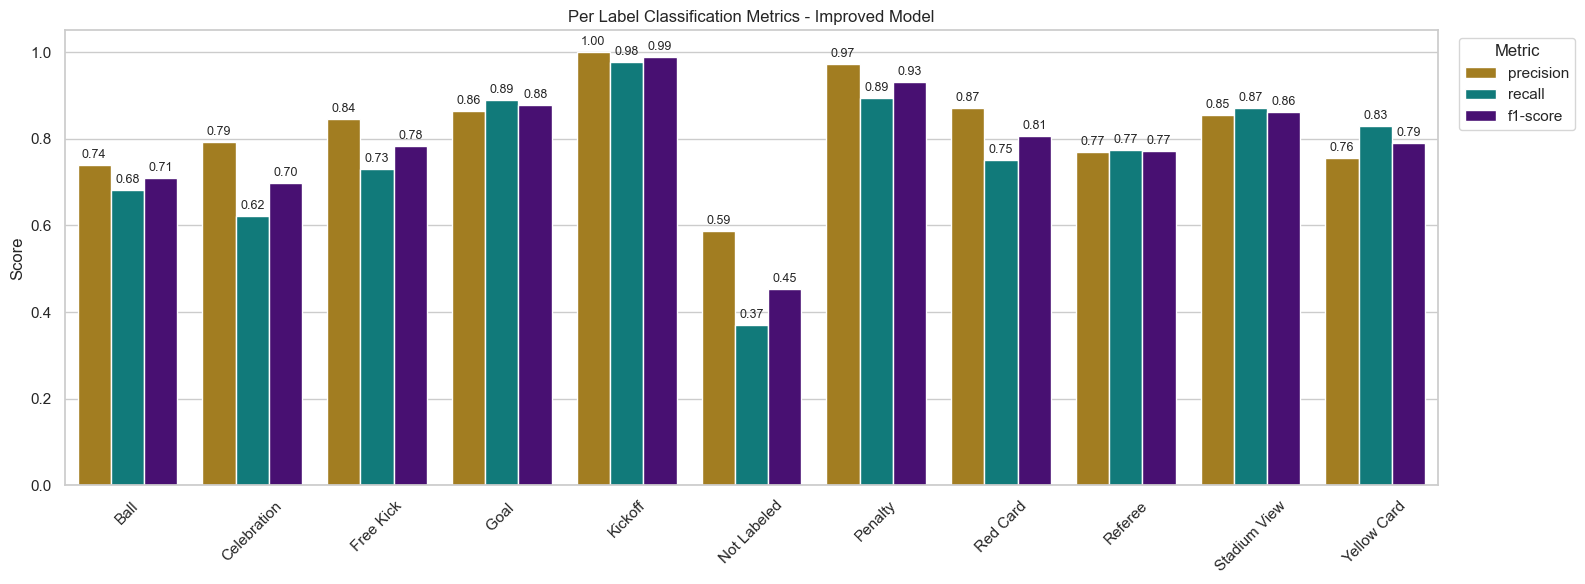

In [40]:
# Plot metrics
report_df = pd.DataFrame(report).transpose() # convert classification report to dataframe to use for visualization and display output
report_df = report_df.loc[unique_labels, ["precision", "recall", "f1-score"]] # isolate just the metrics and labels
report_df = report_df.reset_index().rename(columns={"index": "label"}) # reset index to prepare df for melt
report_df_melt = report_df.melt(id_vars="label", var_name="metric", value_name='score') # melt df to use for plotting

plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")
ax = sns.barplot(data=report_df_melt, x="label", y="score", hue="metric", palette=["darkgoldenrod", "darkcyan", "indigo"])
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=9)
plt.title("Per Label Classification Metrics - Improved Model")
plt.ylabel("Score")
plt.xlabel("")
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.legend(title="Metric", bbox_to_anchor=(1.01, 1), loc="upper left")
plt.tight_layout()
plt.show()

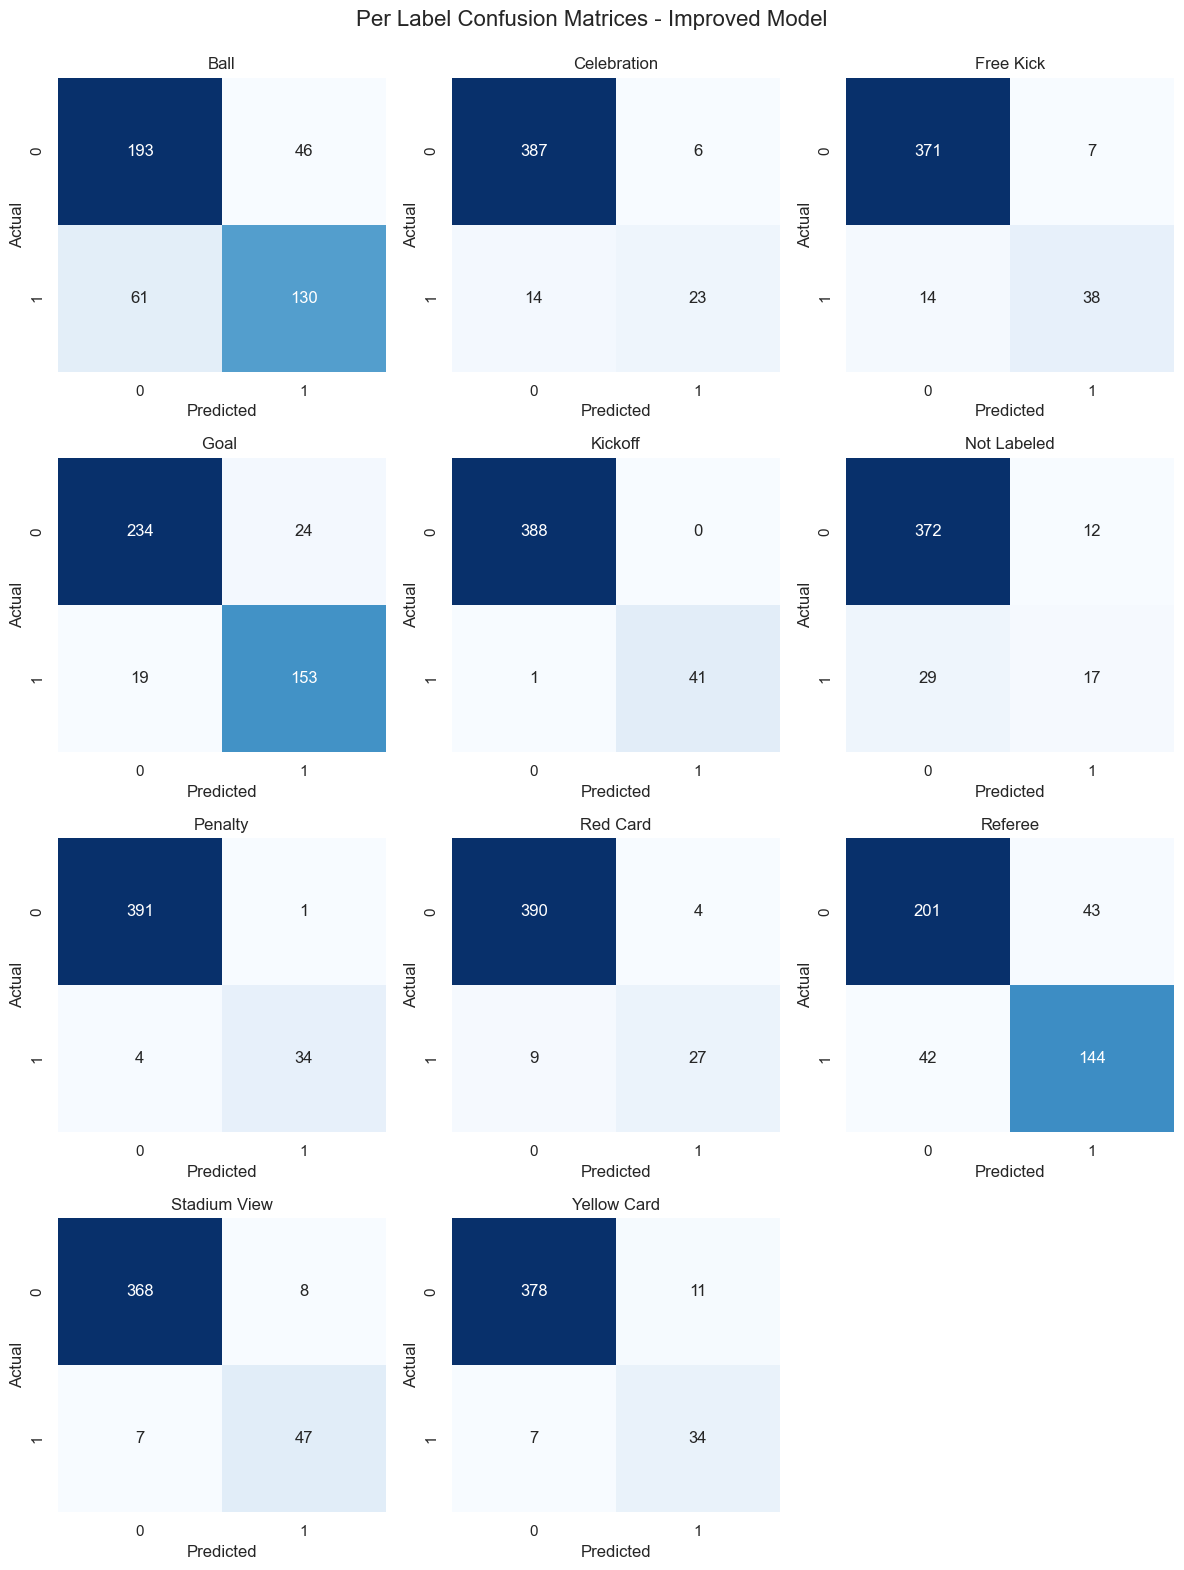

In [ ]:
# Plot all confusion matrices as subplots
plot_rows = 4
plot_cols = math.ceil(len(confusion_matrices)/plot_rows)

fig, axes = plt.subplots(plot_rows, plot_cols, figsize=(4*plot_cols, 4*plot_rows))
axes=axes.flatten()
for i, (matrix, label) in enumerate(zip(confusion_matrices, labels)):
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[i])
    axes[i].set_title(f"{idx_to_label[i]}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Per Label Confusion Matrices - Improved Model\n", fontsize=16)

plt.tight_layout()
plt.show()